# Parameter transfer training

In this notebook we show how to train parameters based on parameter transfers. First, this requires a data set of existing good QAOA angles. Next, the transfer training for an unseen problem instance uses the following steps.

1. Initialize a transfer trainer and load the the data. This data is in a dictionary format where the keys are features and the values are list of good QAOA angles for these features.
2. Upon training, we first compute features of the new cost operator.
3. Based on these features we find the closes matching features in the existing data set.
4. We aggregate the angles corresponding the matched features if there are multiple angle sets.

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from qaoa_training_pipeline.training import TQATrainer, ScipyTrainer
from qaoa_training_pipeline.evaluation import StatevectorEvaluator
from qaoa_training_pipeline.utils.graph_utils import graph_to_operator

from qaoa_training_pipeline.pre_processing.feature_extraction import GraphFeatureExtractor

To create the keys in the data set we need a feature extractor. In this simple example we use average properties of the graphs such as their number of nodes, number of edges, and degree.

In [2]:
feature_extractor = GraphFeatureExtractor(standard_devs=False)

We generate a small database of a few good angles for a set of Erdos-Renyi and Barabasi-Albert graphs.

In [3]:
trainer1 = TQATrainer(StatevectorEvaluator())
trainer2 = ScipyTrainer(StatevectorEvaluator())

In [4]:
def add_data(graph, results, features, instances, reps):
    cost_op = graph_to_operator(graph, pre_factor=-0.5)

    result1 = trainer1.train(cost_op, reps=qaoa_depth)
    result2 = trainer2.train(cost_op, params0=result1["optimized_params"])

    results.append(result2["optimized_params"])
    features.append(feature_extractor(cost_op, reps))
    instances.append(graph)

In [5]:
num_instances, qaoa_depth, num_nodes = 5, 4, 8
instances, results, features = [], [], []

for idx in range(num_instances):
    add_data(
        nx.random_regular_graph(n=num_nodes, d=3, seed=idx),
        results,
        features,
        instances,
        qaoa_depth,
    )
    add_data(
        nx.barabasi_albert_graph(n=num_nodes, m=3, seed=idx),
        results,
        features,
        instances,
        qaoa_depth,
    )

Now we setup our small data set to use when transfering the parameters.

In [6]:
from collections import defaultdict

data = defaultdict(list)

for idx, res in enumerate(results):
    data[features[idx]].append(res)

data.keys()

dict_keys([(4, 8, 12, 3.0, -0.5, 0.42857142857142855), (4, 8, 15, 3.75, -0.5, 0.5357142857142857)])

### Transfer training with exact feature matching

The features of a cost operator $C$ are computed by a function $f(C)$. For a new operator $C'$, in exact feature matching, we look for features $f(C')$ that match exactly in the keys of our data. We will illustrate this by looking at a new cost operator based on a different instance of a Barabasi-Albert graph.

In [7]:
from qaoa_training_pipeline.pre_processing.feature_matching import TrivialFeatureMatcher
from qaoa_training_pipeline.pre_processing.angle_aggregation import AverageAngleAggregator
from qaoa_training_pipeline.training.data_loading import TrivialDataLoader
from qaoa_training_pipeline.training.transfer_trainer import TransferTrainer

Now, we setup the transfer trainer which requires specifying (i) how to load the data, (ii) how to extract the problem features, (iii) how to match the features in the data set, and (iv) how to aggregate the angles in the data.

In [8]:
transfer_trainer = TransferTrainer(
    data_loader=TrivialDataLoader(data),
    feature_extractor=feature_extractor,
    feature_matcher=TrivialFeatureMatcher(),
    angle_aggregator=AverageAngleAggregator(),
    evaluator=StatevectorEvaluator(),
)

In [9]:
graph = nx.barabasi_albert_graph(n=num_nodes, m=3, seed=2 * num_instances)
new_cost_op = graph_to_operator(graph, pre_factor=-0.5)

In [10]:
transfer_res = transfer_trainer.train(new_cost_op, qaoa_depth=4)

We compare the quality of the transfered parameters to a standard SciPy training. As can be seen from the results below, the parameter transfer achieves a quality that is almost identical to the SciPy training but in a fraction of the run-time which is dominated by the evaluation of the energy.

In [11]:
result1 = trainer1.train(new_cost_op, reps=qaoa_depth)
result2 = trainer2.train(new_cost_op, params0=result1["optimized_params"])

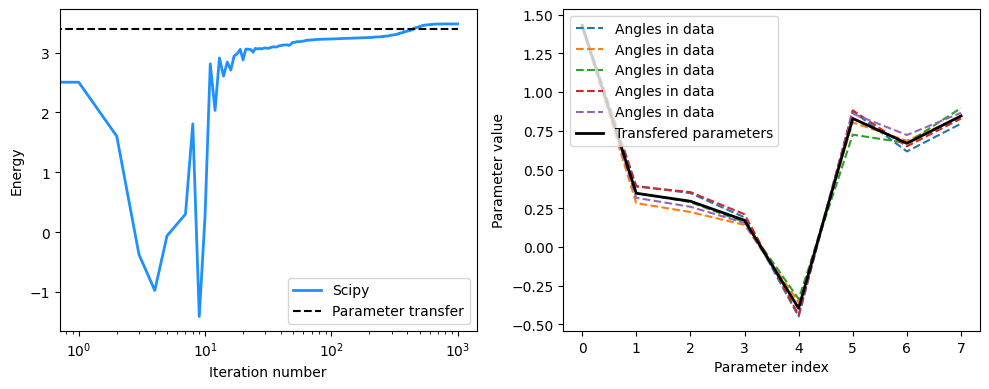

In [12]:
fig, axis = plt.subplots(1, 2, figsize=(10, 4))

trainer2.plot(label="Scipy", fig=fig, axis=axis[0])
axis[0].hlines(transfer_res["energy"], 0, 1000, color="k", ls="--", label="Parameter transfer")
axis[0].set_xscale("log")
axis[0].legend(loc=4)
axis[1].plot(
    np.array(data[feature_extractor(new_cost_op, qaoa_depth)]).T, ls="--", label="Angles in data"
)
axis[1].plot(transfer_res["optimized_qaoa_angles"], lw=2, label="Transfered parameters", color="k")
axis[1].set_xlabel("Parameter index")
axis[1].set_ylabel("Parameter value")
axis[1].legend(loc=0)
fig.tight_layout()

In [13]:
print("Duration of parameter transfer:", transfer_res["train_duration"])
print("Duration of Scipy training:", result1["train_duration"] + result2["train_duration"])

Duration of parameter transfer: 0.007693767547607422
Duration of Scipy training: 8.511801719665527


### Transfer training with nearest feature matching

Now, we consider graphs with features that cannot be found exactly in the exsting data. We will consider an Erdos-Renyi graph that is similar but not identical to the Barabasi Albert and random regular graphs considered until now.

In [14]:
from qaoa_training_pipeline.pre_processing.feature_matching import MinimumNormFeatureMatcher

In [15]:
graph = nx.erdos_renyi_graph(n=num_nodes, p=0.3, seed=2 * num_instances)
new_cost_op = graph_to_operator(graph, pre_factor=-0.5)

In [16]:
feat = transfer_trainer._feature_extractor(new_cost_op, qaoa_depth)

If we attempt to use the existing transfer trainer we cannot find an exact match of the features.

In [17]:
try:
    transfer_trainer.train(new_cost_op, qaoa_depth)
except KeyError:
    print(f"Could not exactly match the features {feat} in the data.")

Could not exactly match the features (4, 8, 7, 1.75, -0.5, 0.25) in the data.


Therefore, we use a feature matcher that is approximate and tries to minimize the dot product between the new features and the ones in the data set.

In [18]:
transfer_trainer2 = TransferTrainer(
    data_loader=TrivialDataLoader(data),
    feature_extractor=feature_extractor,
    feature_matcher=MinimumNormFeatureMatcher(),
    angle_aggregator=AverageAngleAggregator(),
    evaluator=StatevectorEvaluator(),
)

trainer3 = ScipyTrainer(StatevectorEvaluator(), {"options": {"maxiter": 100, "rhobeg": 0.05}})

Again, we compare the quality of the transfered parameters to a standard SciPy training. As can be seen from the results below, the parameter transfer achieves a quality that is almost identical to the SciPy training but in a fraction of the run-time which is dominated by the evaluation of the energy. Furthermore, we can see that if we initialize a SciPy trainer from the transfered parameters we obtain good parameters in fewer iterations of the SciPy trainer.

In [19]:
transfer_res = transfer_trainer2.train(new_cost_op, qaoa_depth)
transfer_res2 = trainer3.train(new_cost_op, params0=transfer_res["optimized_qaoa_angles"])

In [20]:
result1 = trainer1.train(new_cost_op, reps=qaoa_depth)
result2 = trainer2.train(new_cost_op, params0=result1["optimized_params"])

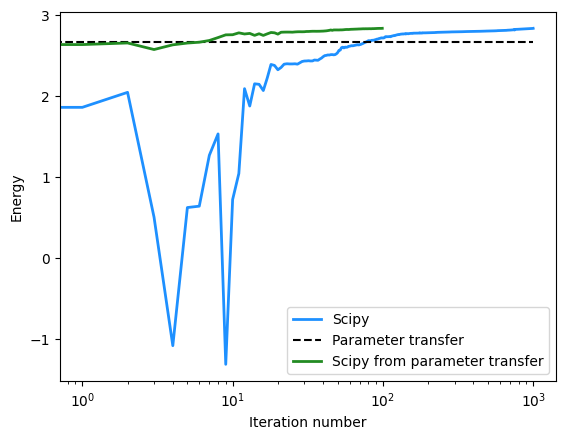

In [21]:
fig, axis = trainer2.plot(label="Scipy")
axis.hlines(transfer_res["energy"], 0, 1000, color="k", ls="--", label="Parameter transfer")
trainer3.plot(fig=fig, axis=axis, label="Scipy from parameter transfer", color="forestgreen")
axis.set_xscale("log")
axis.legend(loc=4)